**数据预处理**

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

need_date_time_columns=1 #是否需要时间作为特征
columns_to_drop=[] #需要删除的列
df = pd.read_csv('data//train.csv', parse_dates=['DateTime'])
# 转换所有应为数值的列为 float（防止字符串类型报错）
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]

# 强制转换为 float，如果有无法解析的值，设置为 NaN
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

df=df.drop(columns=columns_to_drop)
# 添加日期列
df['Date'] = df['DateTime'].dt.date  # 只保留年月日部分

# 计算 sub_metering_remainder（每分钟）
df['sub_metering_remainder'] = (df['Global_active_power'] * 1000 / 60) - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# 定义日级聚合函数
daily_agg = {
    'Global_active_power': 'sum' ,
    'Global_reactive_power': 'sum',
    'Sub_metering_1': 'sum',  # 已是 Wh，每分钟累计可以直接 sum
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'sub_metering_remainder': 'sum',

    'Voltage': 'mean',  # 电压波动，均值即可
    'Global_intensity': 'mean',  # 电流均值也合理

    'RR': 'first',  # 天气指标，一天一个值即可
    'NBJRR1': 'first',
    'NBJRR5': 'first',
    'NBJRR10': 'first',
    'NBJBROU': 'first'
}
for col in columns_to_drop:
    daily_agg.pop(col, None)

# 按日期聚合
df_daily = df.groupby('Date').agg(daily_agg).reset_index()


# 可以选择将日期列转回 datetime 类型
if need_date_time_columns==1:
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    df_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_daily['day_of_month'] = df_daily['Date'].dt.day
    df_daily['month'] = df_daily['Date'].dt.month
    df_daily['quarter'] = df_daily['Date'].dt.quarter
# 查看结果
print("预处理后日级数据：")
print(df_daily.info())
print(df_daily.head())
feature_cols = [col for col in df_daily.columns if col != 'Date']
scaler = MinMaxScaler()
df_daily_scaled = df_daily.copy()
df_daily_scaled[feature_cols] = scaler.fit_transform(df_daily[feature_cols])
print(df_daily_scaled.head())

预处理后日级数据：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    746 non-null    datetime64[ns]
 1   Global_active_power     746 non-null    float64       
 2   Global_reactive_power   746 non-null    float64       
 3   Sub_metering_1          746 non-null    float64       
 4   Sub_metering_2          746 non-null    float64       
 5   Sub_metering_3          746 non-null    float64       
 6   sub_metering_remainder  746 non-null    float64       
 7   Voltage                 746 non-null    float64       
 8   Global_intensity        746 non-null    float64       
 9   RR                      746 non-null    float64       
 10  NBJRR1                  746 non-null    float64       
 11  NBJRR5                  746 non-null    float64       
 12  NBJRR10                 746 non-null    

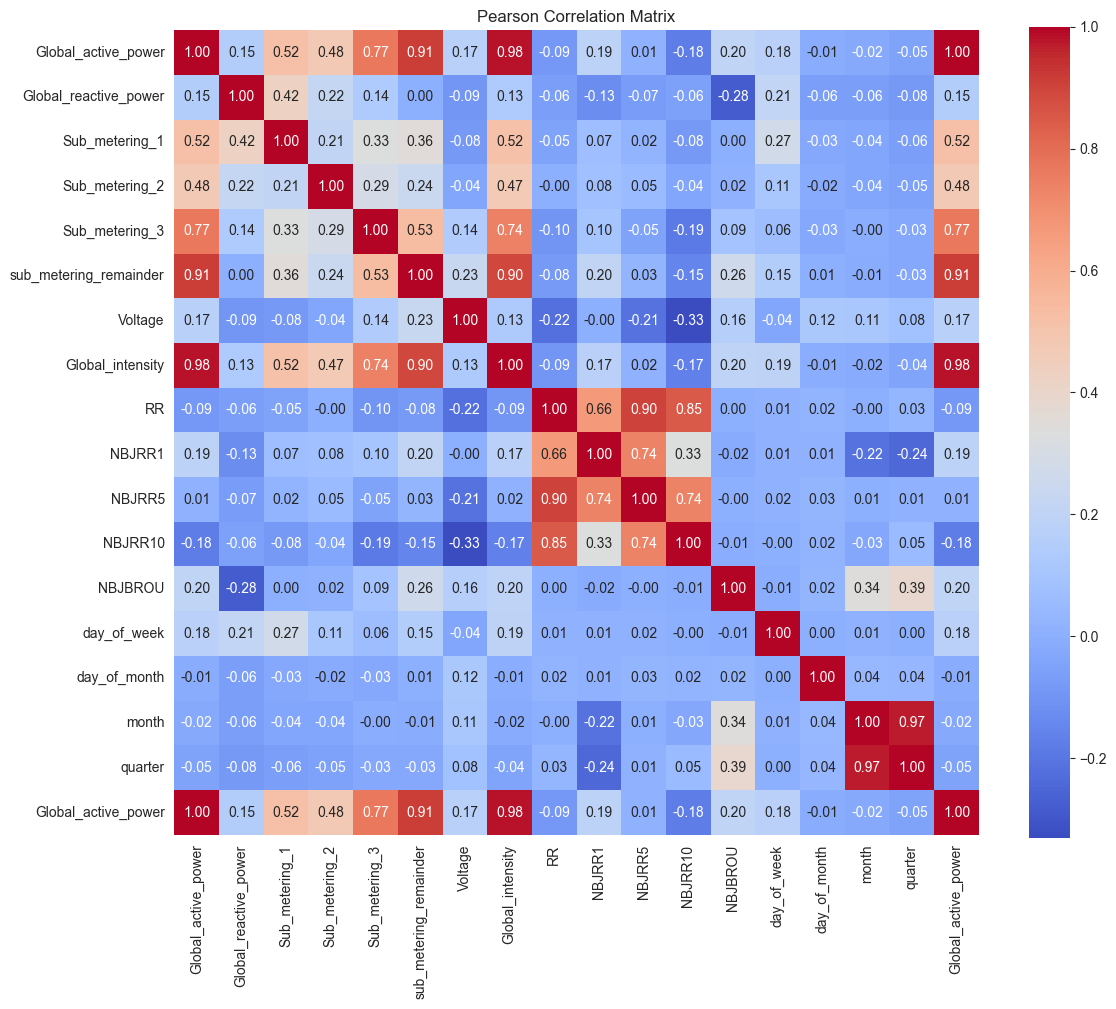

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
target_col = 'Global_active_power'
# 计算皮尔逊相关系数矩阵
corr_matrix = df_daily[feature_cols + [target_col]].corr()

# 可视化热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()

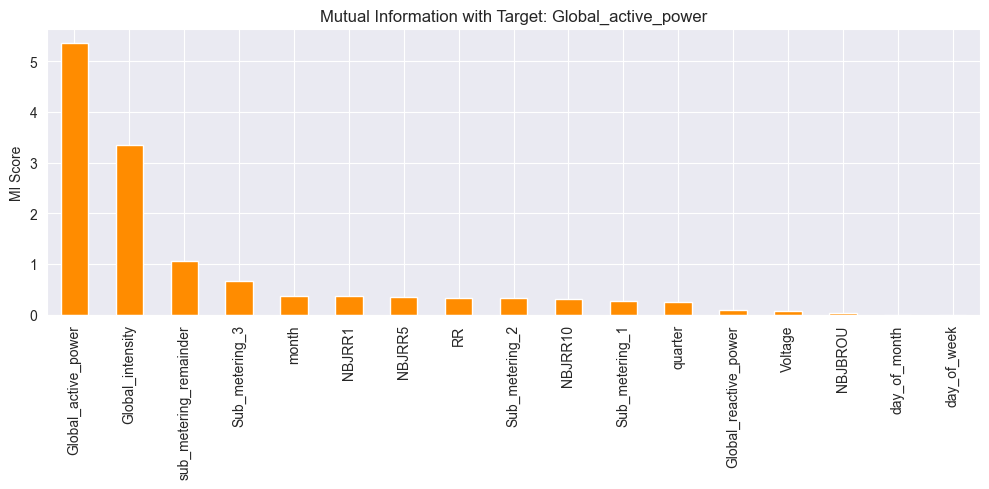

In [18]:
from sklearn.feature_selection import mutual_info_regression

X = df_daily[feature_cols]
y = df_daily[target_col]

mi_scores = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

# 可视化
plt.figure(figsize=(10, 5))
mi_series.plot(kind='bar', color='darkorange')
plt.title(f'Mutual Information with Target: {target_col}')
plt.ylabel('MI Score')
plt.grid(True)
plt.tight_layout()
plt.show()


**构造监督学习数据集**

In [19]:
def create_supervised_data(df, input_window=90, output_window=90, target_col='Global_active_power'):
    """
    构造用于多变量时间序列预测的监督学习样本
    参数：
        df: 已按天聚合的 DataFrame，包含时间序列特征
        input_window: 输入时间步长（例如 90）
        output_window: 预测步长（例如 90 或 365）
        target_col: 预测目标列
    返回：
        X: shape = [样本数, input_window, 特征数]
        y: shape = [样本数, output_window]
    """
    data = df.copy()
    feature_cols = [col for col in data.columns if col != 'Date']

    X_list = []
    y_list = []

    for i in range(len(data) - input_window - output_window + 1):
        x_window = data[feature_cols].iloc[i : i + input_window].values
        y_window = data[target_col].iloc[i + input_window : i + input_window + output_window].values

        if not (np.isnan(x_window).any() or np.isnan(y_window).any()):
            X_list.append(x_window)
            y_list.append(y_window)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


LSTM模型设计+训练

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber
def mae_with_derivative(y_true, y_pred):
    mae = K.mean(K.abs(y_pred - y_true))
    # 一阶差分
    diff_true = y_true[:, 1:] - y_true[:, :-1]
    diff_pred = y_pred[:, 1:] - y_pred[:, :-1]
    diff_loss = K.mean(K.abs(diff_true - diff_pred))
    return mae + 0.5 * diff_loss  # 你可以调节这个系数


def build_lstm_model(input_timesteps, num_features, output_timesteps):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_timesteps, num_features)))
    model.add(Dropout(0.1))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(0.1))
    # model.add(LSTM(512, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(output_timesteps))  # 默认线性激活
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
from tensorflow.keras.callbacks import EarlyStopping
def train_lstm_model(X_train, y_train, X_val, y_val,
                     input_timesteps, num_features, output_timesteps,
                     epochs=50, batch_size=64, n_runs=5):
    from tensorflow.keras import backend as K

    mse_list = []
    mae_list = []
    best_model = None
    best_mse = float('inf')
    # model=None
    for run in range(n_runs):
        print(f"\n===== Run {run+1}/{n_runs} =====")
        model = build_lstm_model(input_timesteps, num_features, output_timesteps)

        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),  # 显式验证集
            callbacks=[early_stopping],
            verbose=2
        )

        # 验证集评估（用于模型选择）
        loss, mae = model.evaluate(X_val, y_val, verbose=0)
        mse = loss

        print(f"Run {run+1} - MSE: {mse:.6f}, MAE: {mae:.6f}")

        mse_list.append(mse)
        mae_list.append(mae)

        if mse < best_mse:
            best_mse = mse
            best_model = model

        K.clear_session()

    results = {
        'mse_mean': np.mean(mse_list),
        'mse_std': np.std(mse_list),
        'mae_mean': np.mean(mae_list),
        'mae_std': np.std(mae_list),
    }

    print("\n===== Summary =====")
    print(f"MSE mean: {results['mse_mean']:.6f}, std: {results['mse_std']:.6f}")
    print(f"MAE mean: {results['mae_mean']:.6f}, std: {results['mae_std']:.6f}")

    return best_model, results

开始训练

In [21]:
#parameters
epochs=100
batch_size=16
n_nums=10
input_window = 90
output_window = 365
target_col = 'Global_active_power'

X_full, y_full = create_supervised_data(df_daily_scaled, input_window, output_window, target_col)
x_df = pd.DataFrame(X_full[0], columns=feature_cols)
y_series = pd.Series(y_full[0], name='Global_active_power')

# print("第", 0, "组 X（输入窗口）:")
# print(x_df)
#
# print("\n第", 0, "组 y（输出窗口）:")
# print(y_series)
print(f"X shape: {X_full.shape}, y shape: {y_full.shape}")
print(f"原始日级数据总天数: {df_daily.shape[0]}")
print(f"用于建模的样本数: {len(X_full)}")

# 划分训练集和验证集
train_ratio = 0.9
split_idx = int(len(X_full) * train_ratio)
X_train, X_val = X_full[:split_idx], X_full[split_idx:]
y_train, y_val = y_full[:split_idx], y_full[split_idx:]

print(f"训练集样本数: {len(X_train)}, 验证集样本数: {len(X_val)}")

num_features = X_train.shape[2]

model, results = train_lstm_model(
    X_train, y_train, X_val, y_val,
    input_window, num_features, output_window,
    epochs=epochs, batch_size=batch_size, n_runs=n_nums
)
model.summary()

X shape: (292, 90, 17), y shape: (292, 365)
原始日级数据总天数: 746
用于建模的样本数: 292
训练集样本数: 262, 验证集样本数: 30

===== Run 1/10 =====
Epoch 1/100


C:\code\MLFinal\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

KeyboardInterrupt



测试集+作图

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_test = pd.read_csv('data/test.csv', header=None)

# Step 2：赋完整列名（按顺序）
df_test.columns = ['DateTime']+numeric_cols
# 数值列转换（如有非数字或缺失，转为NaN）
df_test[numeric_cols] = df_test[numeric_cols].apply(pd.to_numeric, errors='coerce')
# 显式删除不需要字段
df_test = df_test.drop(columns=columns_to_drop)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test['Date'] = df_test['DateTime'].dt.date

# 计算 sub_metering_remainder
df_test['sub_metering_remainder'] = (df_test['Global_active_power'] * 1000 / 60) - (
    df_test['Sub_metering_1'] + df_test['Sub_metering_2'] + df_test['Sub_metering_3'])

# 按天聚合
df_test_daily = df_test.groupby('Date').agg(daily_agg).reset_index()
print(df_test_daily.head())
if need_date_time_columns==1:
    df_test_daily['Date'] = pd.to_datetime(df_test_daily['Date'])
    df_test_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_test_daily['day_of_month'] = df_daily['Date'].dt.day
    df_test_daily['month'] = df_daily['Date'].dt.month
    df_test_daily['quarter'] = df_daily['Date'].dt.quarter
# ========== 关键修改点：丢弃含NaN的天 ==========
df_test_daily_clean = df_test_daily.dropna()
print(f"清洗后测试集天数: {len(df_test_daily_clean)}")


# 归一化（只对干净数据做）
df_test_daily_scaled = df_test_daily_clean.copy()
df_test_daily_scaled[feature_cols] = scaler.transform(df_test_daily_scaled[feature_cols])


def inverse_transform_target(scaler, feature_cols, data_1d, target_col='Global_active_power'):
    """
    把一维的目标列数据逆归一化。
    scaler: 训练时fit的Scaler
    feature_cols: 归一化时所有特征的列名列表
    data_1d: 目标列的一维归一化数据（如full_pred或full_true）
    返回：逆归一化后目标列一维数据
    """
    n = len(data_1d)
    temp = np.zeros((n, len(feature_cols)))
    # 找到目标列索引
    target_idx = feature_cols.index(target_col)
    temp[:, target_idx] = data_1d
    # 逆归一化
    inv_data = scaler.inverse_transform(temp)
    return inv_data[:, target_idx]


X_test_final, y_test_final = create_supervised_data(
    df_test_daily_scaled,
    input_window=input_window,
    output_window=output_window,
    target_col=target_col  # 一般是 'Global_active_power'
)
print(len(X_test_final))
y_pred_final = model.predict(X_test_final)

# 初始化容器
total_days = input_window + (len(y_pred_final) - 1) + output_window
pred_sum = np.zeros(total_days)
true_sum = np.zeros(total_days)
# pred_count = np.zeros(total_days)
# true_count = np.zeros(total_days)
#
# # 多窗口预测融合
# for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
#     start_idx = input_window + i
#     end_idx = start_idx + output_window
#
#     pred_sum[start_idx:end_idx] += pred
#     pred_count[start_idx:end_idx] += 1
#
#     true_sum[start_idx:end_idx] += true
#     true_count[start_idx:end_idx] += 1
#
# # 平均融合
# pred_avg = np.zeros_like(pred_sum)
# true_avg = np.zeros_like(true_sum)
#
# pred_avg[pred_count > 0] = pred_sum[pred_count > 0] / pred_count[pred_count > 0]
# true_avg[true_count > 0] = true_sum[true_count > 0] / true_count[true_count > 0]

# 替代平均融合：取最后一次预测
for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
    start_idx = input_window + i
    end_idx = start_idx + output_window

    pred_sum[start_idx:end_idx] = pred  # 直接覆盖
    true_sum[start_idx:end_idx] = true

# 取预测部分
full_pred = pred_sum[input_window:]
full_true = true_sum[input_window:]

# 反归一化
full_pred_inv = inverse_transform_target(scaler, feature_cols, full_pred, target_col)
full_true_inv = inverse_transform_target(scaler, feature_cols, full_true, target_col)

# 时间轴
days = np.arange(len(full_pred))



plt.figure(figsize=(14, 5))
plt.plot(days, full_true_inv, label='Ground Truth', color='blue', linewidth=2)
plt.plot(days, full_pred_inv, label='Merged Prediction', color='orange', linewidth=2)
plt.xlabel('Day from Prediction Start')
plt.ylabel('Global Active Power (kW)')  # 单位改成实际单位
plt.title('Merged 365-day Predictions vs Ground Truth (Actual Values)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
true_values_to_show = full_true_inv
pred_values_to_show = full_pred_inv

# 打印前30天（或根据需要改）
print("Day | Ground Truth (kW) | Merged Prediction (kW) | Absolute Error")
print("-" * 50)
for i in range(min(30, len(true_values_to_show))):
    true_val = true_values_to_show[i]
    pred_val = pred_values_to_show[i]
    error = abs(true_val - pred_val)
    print(f"{i:3d} | {true_val:17.4f} | {pred_val:19.4f} | {error:14.4f}")



# MSE
mse = mean_squared_error(true_values_to_show, pred_values_to_show)

# RMSE
rmse = mse ** 0.5

# MAE
mae = mean_absolute_error(true_values_to_show, pred_values_to_show)
errors = pred_values_to_show- true_values_to_show
std_dev = np.std(errors)

print(f"测试集评估指标:")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"预测误差标准差: {std_dev:.6f}")

In [ ]:
df_test_daily_clean.head()

In [ ]:
# def inverse_transform_target_2d(scaler, feature_cols, data_2d, target_col='Global_active_power'):
#     n_samples, n_steps = data_2d.shape
#     inv_data = np.zeros_like(data_2d)
#     target_idx = feature_cols.index(target_col)
#
#     for i in range(n_samples):
#         temp = np.zeros((n_steps, len(feature_cols)))
#         temp[:, target_idx] = data_2d[i]
#         inv_temp = scaler.inverse_transform(temp)
#         inv_data[i] = inv_temp[:, target_idx]
#     return inv_data
#
# # 调用示例
# y_test_inv = inverse_transform_target_2d(scaler, feature_cols, y_test_final)
# y_pred_inv = inverse_transform_target_2d(scaler, feature_cols, y_pred_final)
#
# days2 = np.arange(90)
# plt.figure(figsize=(14, 5))
# plt.plot(days2, y_test_inv[0], label='Ground Truth', color='blue', linewidth=2)
# plt.plot(days2, y_pred_inv[0], label='Merged Prediction', color='orange', linestyle='--', linewidth=2)
# plt.xlabel('Day from Prediction Start')
# plt.ylabel('Global Active Power (kW)')  # 单位改成实际单位
# plt.title('90-day Predictions vs Ground Truth')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()